### Static plot

In [1]:
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [2]:

# ---------------------------
# INPUT PATHS
# ---------------------------
excel_path = r"C:\Users\daves\OneDrive\Pessoal\Notebooks\Densidade demográfica - Censo 2022\ipeadata[21-08-2025-10-11].xls"
shapefile_path = r"C:\Users\daves\OneDrive\Pessoal\Notebooks\Projeto - Economia sustentável na Amazônia\BR_Municipios_2024\BR_Municipios_2024.shp"

In [3]:

# ---------------------------
# READ & NORMALIZE EXCEL
# ---------------------------
df = pd.read_excel(excel_path, engine="xlrd")
df.columns = [str(c).strip() for c in df.columns]

# Unify possible header variants
if "Codigo" not in df.columns and "Código" in df.columns:
    df = df.rename(columns={"Código": "Codigo"})

# Create 7-digit municipal code
df["CD_MUN"] = df["Codigo"].astype(str).str.replace(r"\D", "", regex=True).str.zfill(7)

# Detect municipality name column (with/without accent)
muni_col = None
for c in df.columns:
    if re.fullmatch(r"Munic[ií]pio", c, flags=re.I):
        muni_col = c
        break
if muni_col is None:
    raise ValueError("Municipality name column not found (e.g., 'Município').")

# Convert year columns that look like years to int
col_rename = {}
for c in df.columns:
    m = re.fullmatch(r"\s*(19\d{2}|20\d{2})\s*", c)
    if m:
        col_rename[c] = int(m.group(1))
if col_rename:
    df = df.rename(columns=col_rename)

# Expected historical columns; keep those present
year_cols_expected = [1970, 1980, 1991, 1996, 2000, 2007, 2010, 2022]
year_cols = [y for y in year_cols_expected if y in df.columns]
if 2022 not in year_cols:
    raise ValueError("Column 2022 not found after normalization.")

# Keep a clean projection table with years preserved
df_years = df[["CD_MUN", muni_col, "Sigla"] + year_cols].copy() if "Sigla" in df.columns \
           else df[["CD_MUN", muni_col] + year_cols].copy()

In [4]:
# ---------------------------
# READ SHAPEFILE & NORMALIZE
# ---------------------------
g = gpd.read_file(shapefile_path)

if "CD_MUN" not in g.columns:
    detected = None
    for c in g.columns:
        try:
            s = g[c].astype(str).str.replace(r"\D", "", regex=True).str.zfill(7)
            if (s.str.len() == 7).mean() > 0.9:
                detected = c
                break
        except Exception:
            pass
    if detected is None:
        raise ValueError("Municipal code column not found in shapefile.")
    g = g.rename(columns={detected: "CD_MUN"})

g["CD_MUN"] = g["CD_MUN"].astype(str).str.replace(r"\D", "", regex=True).str.zfill(7)

# Ensure area in km²
if "AREA_KM2" not in g.columns:
    # Assign datum if missing, then project to meters
    if g.crs is None:
        g = g.set_crs(4674, allow_override=True)  # SIRGAS 2000
    g_m = g.to_crs(5880)  # SIRGAS 2000 / Brazil Polyconic (meters)
    g["AREA_KM2"] = g_m.geometry.area / 1_000_000.0

In [5]:
# ---------------------------
# MERGE SHAPE + POPULATION (preserve all year_cols)
# ---------------------------
g = g.merge(df_years, on="CD_MUN", how="left")

# ---------------------------
# DENSITY 2022
# ---------------------------
g["pop_2022"] = pd.to_numeric(g[2022], errors="coerce")
g["densidade_2022"] = g["pop_2022"] / g["AREA_KM2"]

# ---------------------------
# PREP LONG TABLE FOR MODELING
# ---------------------------
df_long = df.melt(
    id_vars=["CD_MUN", muni_col] + (["Sigla"] if "Sigla" in df.columns else []),
    value_vars=year_cols,
    var_name="year",
    value_name="pop"
).dropna(subset=["pop"]).sort_values(["CD_MUN", "year"])

df_long = df_long[df_long["pop"] > 0].copy()
df_long["CD_MUN"] = df_long["CD_MUN"].astype(str).str.replace(r"\D", "", regex=True).str.zfill(7)
df_long["year"] = df_long["year"].astype(float)
df_long["pop"] = df_long["pop"].astype(float)

# ---------------------------
# FORECAST TO 2050 (log → exp fallback)
# ---------------------------
target_year = 2050
rows = []

for cd_mun, grp in df_long.groupby("CD_MUN"):
    t = grp["year"].values
    y = grp["pop"].values
    pop_2050 = np.nan
    model_used = None

    if y.size >= 2:
        # Logarithmic: y = a + b*ln(t)
        try:
            X_log = np.vstack([np.ones_like(t), np.log(t)]).T
            beta, *_ = np.linalg.lstsq(X_log, y, rcond=None)
            pred = beta[0] + beta[1] * np.log(target_year)
            if np.isfinite(pred) and pred > 0:
                pop_2050 = float(pred)
                model_used = "logarithmic"
        except Exception:
            pass

        # Exponential fallback: y = exp(a + b*t)
        if not np.isfinite(pop_2050):
            try:
                ly = np.log(y)
                X_exp = np.vstack([np.ones_like(t), t]).T
                beta, *_ = np.linalg.lstsq(X_exp, ly, rcond=None)
                pred = np.exp(beta[0] + beta[1] * target_year)
                if np.isfinite(pred) and pred > 0:
                    pop_2050 = float(pred)
                    model_used = "exponential"
            except Exception:
                pass

    rows.append({"CD_MUN": str(cd_mun).zfill(7), "pop_2050": pop_2050, "model": model_used})

df_fore = pd.DataFrame(rows)
# Ensure key column exists and is clean
df_fore["CD_MUN"] = df_fore["CD_MUN"].astype(str).str.replace(r"\D", "", regex=True).str.zfill(7)

# ---------------------------
# MERGE FORECAST BACK, COMPUTE DENSITY 2050
# ---------------------------
g["CD_MUN"] = g["CD_MUN"].astype(str).str.replace(r"\D", "", regex=True).str.zfill(7)
g = g.merge(df_fore, on="CD_MUN", how="left")
g["densidade_2050"] = g["pop_2050"] / g["AREA_KM2"]

# ---------------------------
# CLASS BINS (fixed) + COLORS
# ---------------------------
bins = [0, 1, 10, 25, 100, 13124]
labels_pt = ["0 – 1", "1 – 10", "10 – 25", "25 – 100", "100 – 13124"]
colors = ["#ffffcc", "#ffeda0", "#feb24c", "#f03b20", "#bd0026"]
color_map = {lab: col for lab, col in zip(labels_pt, colors)}

g["class_2022"] = pd.cut(g["densidade_2022"], bins=bins, labels=labels_pt, include_lowest=True, right=False)
g["class_2050"] = pd.cut(g["densidade_2050"], bins=bins, labels=labels_pt, include_lowest=True, right=False)

# ---------------------------
# STATE LAYER FOR BORDERS/LABELS
# ---------------------------
sigla_col = None
for c in ["SIGLA_UF", "SIGLA", "UF", "Sigla"]:
    if c in g.columns:
        sigla_col = c
        break
if sigla_col is None:
    raise ValueError("State abbreviation column not found in merged data (e.g., 'SIGLA_UF' or 'Sigla').")

states = g[[sigla_col, "geometry"]].dissolve(by=sigla_col, as_index=False)
states["cx"] = states.geometry.representative_point().x
states["cy"] = states.geometry.representative_point().y

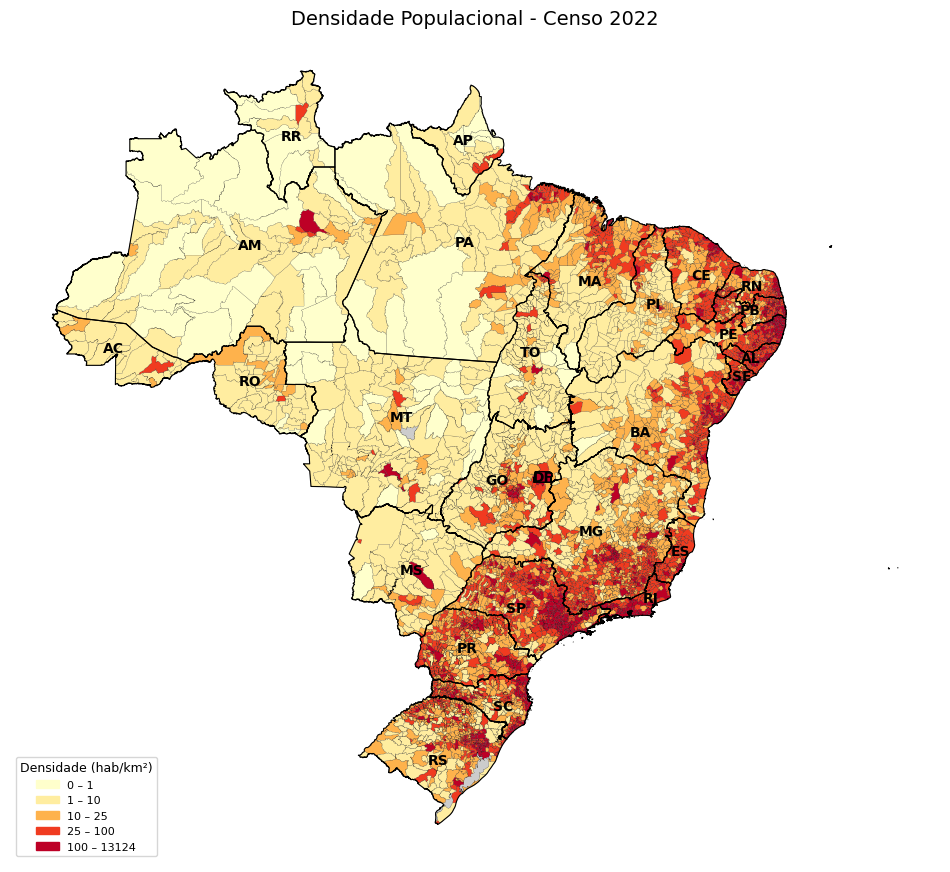

In [6]:
# ---------------------------
# STATIC MAP — 2022
# ---------------------------
colors_2022 = g["class_2022"].map(color_map).astype(object).fillna("#cccccc")
fig, ax = plt.subplots(figsize=(12, 12))
g.plot(ax=ax, color=colors_2022, edgecolor="black", linewidth=0.1, zorder=1)
states.boundary.plot(ax=ax, color="black", linewidth=0.8, zorder=2)
for _, r in states.iterrows():
    ax.text(r["cx"], r["cy"], r[sigla_col], ha="center", va="center",
            fontsize=10, fontweight="bold", color="black", zorder=3)

legend_patches = [mpatches.Patch(color=colors[i], label=labels_pt[i]) for i in range(len(labels_pt))]
ax.legend(handles=legend_patches, title="Densidade (hab/km²)",
          loc="lower left", fontsize=8, title_fontsize=9, frameon=True)
ax.set_title("Densidade Populacional - Censo 2022", fontsize=14)
ax.set_axis_off()
plt.savefig("densidade_2022.jpg", dpi=1200, bbox_inches="tight", pad_inches=0.2)
plt.show()

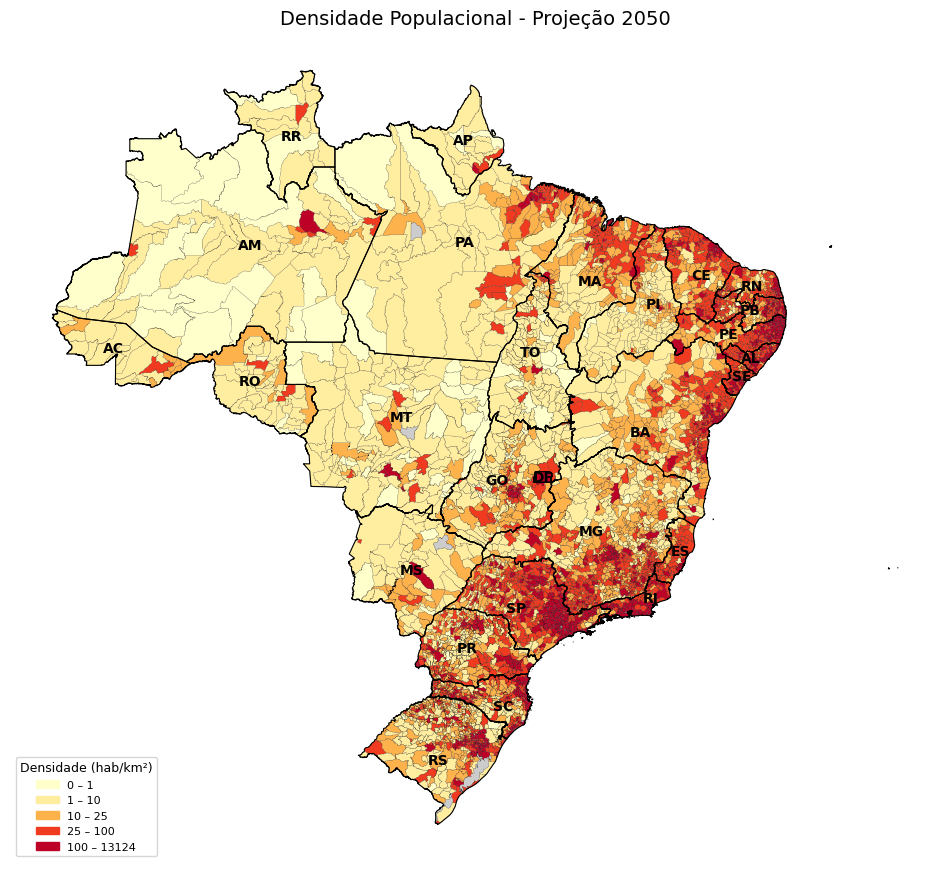

Saved files: densidade_2022.jpg, densidade_2050.jpg, municipios_pop_densidade_1970_2050.xlsx


In [7]:
# ---------------------------
# STATIC MAP — 2050 (single block, cleaned)
# ---------------------------
colors_2050 = g["class_2050"].map(color_map).astype(object).fillna("#cccccc")

fig, ax = plt.subplots(figsize=(12, 12))
g.plot(ax=ax, color=colors_2050, edgecolor="black", linewidth=0.1, zorder=1)
states.boundary.plot(ax=ax, color="black", linewidth=0.8, zorder=2)
for _, r in states.iterrows():
    ax.text(r["cx"], r["cy"], r[sigla_col], ha="center", va="center",
            fontsize=10, fontweight="bold", color="black", zorder=3)

legend_patches = [mpatches.Patch(color=colors[i], label=labels_pt[i]) for i in range(len(labels_pt))]
ax.legend(handles=legend_patches, title="Densidade (hab/km²)",
          loc="lower left", fontsize=8, title_fontsize=9, frameon=True)
ax.set_title("Densidade Populacional - Projeção 2050", fontsize=14)
ax.set_axis_off()
plt.savefig("densidade_2050.jpg", dpi=1200, bbox_inches="tight", pad_inches=0.2)
plt.show()

# ---------------------------
# EXPORT TABLE TO XLSX (single block, cleaned)
# ---------------------------
out = g[["CD_MUN", muni_col, sigla_col] + year_cols +
        ["AREA_KM2", "pop_2022", "densidade_2022",
         "pop_2050", "densidade_2050", "model"]].copy()

out.to_excel("municipios_pop_densidade_1970_2050.xlsx",
             index=False, engine="openpyxl")

print("Saved files:",
      "densidade_2022.jpg, densidade_2050.jpg, municipios_pop_densidade_1970_2050.xlsx")

### Interactive plot

In [8]:
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.graph_objects as go
import plotly.io as pio
import orjson

# ---------------------------
# Update your file paths
# ---------------------------
excel_path = r"C:\Users\daves\OneDrive\Pessoal\Notebooks\Densidade demográfica - Censo 2022\municipios_pop_densidade_1970_2050.xlsx"
shapefile_path = r"C:\Users\daves\OneDrive\Pessoal\Notebooks\Projeto - Economia sustentável na Amazônia\BR_Municipios_2024\BR_Municipios_2024.shp"

print("Reading Excel…")
df = pd.read_excel(excel_path)
# Clean column names in Excel file to avoid issues with spaces
df.columns = [str(c).strip() for c in df.columns]


# Detect municipality code column in Excel
col_cd = None
for c in df.columns:
    if str(c).upper() in ("CD_MUN", "CODIGO", "CÓDIGO", "COD_MUN", "CODMUN", "CD_MUNICIPIO", "ID_MUNICIPIO"):
        col_cd = c
        break
if col_cd is None:
    raise ValueError("Could not find municipality code column in Excel (e.g., 'CD_MUN' or 'Codigo').")

# Detect municipality name column in Excel
col_mun = None
for c in df.columns:
    if re.fullmatch(r"Munic[ií]pio", str(c), flags=re.I):
        col_mun = c
        break
if col_mun is None:
    for c in ["NM_MUN", "nome_municipio", "municipio", "Municipio", "Municipality"]:
        if c in df.columns:
            col_mun = c
            break
if col_mun is None:
    col_mun = "Municipio"
    df[col_mun] = df[col_cd].astype(str)

# Normalize Excel code and ensure densities
df["CD_MUN"] = df[col_cd].astype(str).str.replace(r"\D", "", regex=True).str.zfill(7)
if "densidade_2022" not in df.columns and {"pop_2022","AREA_KM2"} <= set(df.columns):
    df["densidade_2022"] = pd.to_numeric(df["pop_2022"], errors="coerce") / pd.to_numeric(df["AREA_KM2"], errors="coerce")
if "densidade_2050" not in df.columns and {"pop_2050","AREA_KM2"} <= set(df.columns):
    df["densidade_2050"] = pd.to_numeric(df["pop_2050"], errors="coerce") / pd.to_numeric(df["AREA_KM2"], errors="coerce")
if "densidade_2022" not in df.columns or "densidade_2050" not in df.columns:
    raise ValueError("Excel must contain 'densidade_2022' and 'densidade_2050' or enough columns to compute them (pop_* and AREA_KM2).")

print("Reading shapefile…")
gdf = gpd.read_file(shapefile_path)

# Detect shapefile code column
shape_cd = None
for c in gdf.columns:
    try:
        s = gdf[c].astype(str).str.replace(r"\D", "", regex=True).str.zfill(7)
        if (s.str.len() == 7).mean() > 0.9:
            shape_cd = c
            break
    except Exception:
        pass
if shape_cd is None:
    raise ValueError("Could not find a municipality code column in the shapefile.")
gdf = gdf.rename(columns={shape_cd: "CD_MUN"})
gdf["CD_MUN"] = gdf["CD_MUN"].astype(str).str.replace(r"\D", "", regex=True).str.zfill(7)


# Before merging, find columns that exist in BOTH dataframes (except the merge key 'CD_MUN')
cols_in_both = [col for col in gdf.columns if col in df.columns and col != 'CD_MUN']
if cols_in_both:
    print(f"Found duplicate columns to drop from Excel before merge: {cols_in_both}")
    df_for_merge = df.drop(columns=cols_in_both)
else:
    df_for_merge = df

print("Merging Excel + geometries…")
g = gdf.merge(df_for_merge, on="CD_MUN", how="inner")
# --------------------


# Municipality name column in merged GeoDataFrame
muni_col = None
for c in g.columns:
    if re.fullmatch(r"Munic[ií]pio", str(c), flags=re.I):
        muni_col = c
        break
if muni_col is None:
    for c in ["NM_MUN", "nome_municipio", "municipio", "Municipio", "Municipality", col_mun]:
        if c in g.columns:
            muni_col = c
            break
if muni_col is None:
    muni_col = "Municipio"
    g[muni_col] = g["CD_MUN"]

# Robust binning
bins = [0, 1, 10, 25, 100, np.inf]
labels_pt = ["0 – 1", "1 – 10", "10 – 25", "25 – 100", "100+"]
g["class_2022"] = pd.cut(g["densidade_2022"], bins=bins, labels=labels_pt, include_lowest=True, right=False).cat.add_categories("Sem dado").fillna("Sem dado")
g["class_2050"] = pd.cut(g["densidade_2050"], bins=bins, labels=labels_pt, include_lowest=True, right=False).cat.add_categories("Sem dado").fillna("Sem dado")

# Geometry processing
g = g[g.geometry.notna() & ~g.geometry.is_empty].copy()
if not g.geometry.is_valid.all():
    g["geometry"] = g.geometry.buffer(0)
    g = g[g.geometry.notna() & ~g.geometry.is_empty]
if g.crs is None: g = g.set_crs(4674, allow_override=True)
g_metric = g.to_crs(5880)
g_metric["geometry"] = g_metric.geometry.simplify(2000, preserve_topology=True)
g_web = g_metric.to_crs(4326)

# State layer creation
sigla_col = None
for c in ["SIGLA_UF", "SG_UF", "UF", "sigla_uf"]:
    if c in g.columns:
        sigla_col = c
        break
if sigla_col is None: raise ValueError("A state abbreviation column (e.g., 'SIGLA_UF') is required but was not found.")
dissolve_col = sigla_col
states_metric = g_metric[[dissolve_col, "geometry"]].dissolve(by=dissolve_col, as_index=False)
states_web = states_metric.to_crs(4326)
states_web["cx"] = states_web.geometry.representative_point().x
states_web["cy"] = states_web.geometry.representative_point().y
states_geojson = orjson.loads(states_web.to_json().encode("utf-8"))

# Color map & GeoJSON
color_map = {"0 – 1":"#ffffcc", "1 – 10":"#ffeda0", "10 – 25":"#feb24c", "25 – 100":"#f03b20", "100+":"#bd0026", "Sem dado":"#cccccc"}
geojson_obj = orjson.loads(g_web.to_json().encode("utf-8"))

# Build figure
fig = go.Figure()

# 2022 layers
for label in labels_pt + ["Sem dado"]:
    mask = (g_web["class_2022"] == label)
    if not mask.any(): continue
    locs = g_web.loc[mask, "CD_MUN"].tolist()
    dens_vals = g_web.loc[mask, "densidade_2022"].fillna(0).astype(float).round(2).tolist()
    muni_vals = g_web.loc[mask, muni_col].astype(str).tolist()
    hover_text = [f"<b>{m}</b><br>Densidade 2022: {d:.2f} hab/km²<extra></extra>" for m, d in zip(muni_vals, dens_vals)]
    fig.add_trace(go.Choropleth(geojson=geojson_obj, locations=locs, z=[1]*len(locs), featureidkey="properties.CD_MUN", colorscale=[[0, color_map.get(label)], [1, color_map.get(label)]], showscale=False, name=label, hovertemplate="%{hovertext}", hovertext=hover_text, visible=True, marker_line_width=0.3, marker_line_color="black"))

# 2050 layers
for label in labels_pt + ["Sem dado"]:
    mask = (g_web["class_2050"] == label)
    if not mask.any(): continue
    locs = g_web.loc[mask, "CD_MUN"].tolist()
    dens_vals = g_web.loc[mask, "densidade_2050"].fillna(0).astype(float).round(2).tolist()
    muni_vals = g_web.loc[mask, muni_col].astype(str).tolist()
    hover_text = [f"<b>{m}</b><br>Densidade 2050: {d:.2f} hab/km²<extra></extra>" for m, d in zip(muni_vals, dens_vals)]
    fig.add_trace(go.Choropleth(geojson=geojson_obj, locations=locs, z=[1]*len(locs), featureidkey="properties.CD_MUN", colorscale=[[0, color_map.get(label)], [1, color_map.get(label)]], showscale=False, name=label, hovertemplate="%{hovertext}", hovertext=hover_text, visible=False, marker_line_width=0.3, marker_line_color="black"))

# State borders and labels
if states_geojson:
    fig.add_trace(go.Choropleth(geojson=states_geojson, locations=states_web[dissolve_col], z=[1]*len(states_web), featureidkey=f"properties.{dissolve_col}", colorscale=[[0, 'rgba(0,0,0,0)'],[1,'rgba(0,0,0,0)']], showscale=False, hoverinfo="skip", name="Estados", marker_line_width=0.6, marker_line_color="black"))
    fig.add_trace(go.Scattergeo(lon=states_web["cx"], lat=states_web["cy"], text=states_web[dissolve_col], mode="text", textfont=dict(size=18, color="#FFFFFF", family="Arial Black"), hoverinfo="skip", showlegend=False))
    fig.add_trace(go.Scattergeo(lon=states_web["cx"], lat=states_web["cy"], text=states_web[dissolve_col], mode="text", textfont=dict(size=18, color="#111111", family="Arial Black"), hoverinfo="skip", showlegend=False))

# Visibility vectors for year selector
ncat, extra = len(labels_pt) + 1, 3 if states_geojson else 0
visible_2022, visible_2050 = [True]*ncat + [False]*ncat + [True]*extra, [False]*ncat + [True]*ncat + [True]*extra

# Layout
fig.update_layout(
    title={'text':"Densidade Populacional - Censo 2022", 'x':0.5, 'xanchor':'center'},
    updatemenus=[dict(type="dropdown", x=0.01, y=0.98, xanchor="left", yanchor="top", bgcolor="rgba(255,255,255,0.95)", bordercolor="rgba(0,0,0,0.3)", borderwidth=2,
        buttons=[
            dict(label="📅 2022 - Censo", method="update", args=[{"visible": visible_2022}, {"title.text": "Densidade Populacional - Censo 2022"}]),
            dict(label="📅 2050 - Projeção", method="update", args=[{"visible": visible_2050}, {"title.text": "Densidade Populacional - Projeção 2050"}])
        ])],
    margin=dict(l=10, r=10, t=50, b=60), autosize=True, showlegend=False)
fig.update_geos(fitbounds="locations", visible=False)

# JavaScript for legend and resizing
post_js = """
var plotDiv = document.getElementById('mapa_densidade');
var legend = document.getElementById('legend-panel');
if (!legend) {
  legend = document.createElement('div');
  legend.id = 'legend-panel';
  Object.assign(legend.style, {
    position: 'absolute', bottom: '10px', left: '10px', right: '10px',
    background: 'rgba(255,255,255,0.95)', border: '1px solid rgba(0,0,0,0.2)',
    borderRadius: '6px', padding: '8px', fontFamily: 'Arial, sans-serif',
    fontSize: '12px', zIndex: '1000'
  });
  plotDiv.parentElement.appendChild(legend);
}
legend.innerHTML = `
  <div style="display: flex; justify-content: center; align-items: center; flex-wrap: wrap; gap: 15px;">
    <div style="font-weight:bold;">Densidade (hab/km²):</div>
    <div style="display: flex; align-items: center; gap: 4px;"><span style="color:#ffffcc;font-size:16px; -webkit-text-stroke: 0.5px black;">●</span> 0 – 1</div>
    <div style="display: flex; align-items: center; gap: 4px;"><span style="color:#ffeda0;font-size:16px; -webkit-text-stroke: 0.5px black;">●</span> 1 – 10</div>
    <div style="display: flex; align-items: center; gap: 4px;"><span style="color:#feb24c;font-size:16px; -webkit-text-stroke: 0.5px black;">●</span> 10 – 25</div>
    <div style="display: flex; align-items: center; gap: 4px;"><span style="color:#f03b20;font-size:16px; -webkit-text-stroke: 0.5px black;">●</span> 25 – 100</div>
    <div style="display: flex; align-items: center; gap: 4px;"><span style="color:#bd0026;font-size:16px; -webkit-text-stroke: 0.5px black;">●</span> 100+</div>
    <div style="display: flex; align-items: center; gap: 4px;"><span style="color:#cccccc;font-size:16px; -webkit-text-stroke: 0.5px black;">●</span> Sem dado</div>
  </div>`;
function resizePlot() {
  Plotly.relayout('mapa_densidade', {
    'height': window.innerHeight - 10, 'margin.r': 10, 'margin.b': 60
  });
}
window.addEventListener('resize', resizePlot);
setTimeout(resizePlot, 50);
"""

# Export HTML
output_filename = "mapa_densidade.html"
print(f"Exporting: {output_filename}")
pio.write_html(fig, file=output_filename, include_plotlyjs="cdn", full_html=True,
               config={"displayModeBar": True, "displaylogo": False, "responsive": True},
               auto_open=True, div_id="mapa_densidade", post_script=post_js)
print("✅ Done.")

Reading Excel…
Reading shapefile…
Found duplicate columns to drop from Excel before merge: ['SIGLA_UF', 'AREA_KM2']
Merging Excel + geometries…
Exporting: mapa_densidade.html
✅ Done.
